# About Dataset

<img src="https://th.bing.com/th/id/R.a672705de96542b9f120f7dabc9dbf9a?rik=iEzFJf%2blYr0Acw&riu=http%3a%2f%2fpediatricophthalmologypa.com%2fwp-content%2fuploads%2f2014%2f01%2fDiabetic-Retinopathy-Blindness.png&ehk=vb2qvyFjNGpv6VGQWbnvpiIgpGtoCRrrPZKkJ4DMNMc%3d&risl=&pid=ImgRaw&r=0" alt="centered image" image align ="right" class="sc-hTnXLe UAvdY" 
     width = '500' 
     height ='1000'/>

## Total Class Labels = 5

## Total Images = 2750

### 1. Healthy (Not DR) = 1000

### 2. Mild DR = 370

### 3. Moderate DR = 900

### 4. Proliferative DR = 290

### 5. Severe DR = 190

### DR: Diabetic Retinopathy



# 1 Import libraries

In [1]:
!pip install -U imbalanced-learn

import os
import shutil
import pathlib
import PIL
import cv2
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import random
import itertools

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow .keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from PIL import Image, UnidentifiedImageError

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


print("All done")


All done


# 2 Read Data

## A- convert files to lists

In [234]:
Path_data = '/kaggle/input/diabetic-retinopathy-dataset'
data = os.listdir(Path_data)
Healthy = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Healthy')
Mild = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Mild DR')
Moderate = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Moderate DR')
Proliferate = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Proliferate DR')
Severe = os.listdir('/kaggle/input/diabetic-retinopathy-dataset/Severe DR')

In [235]:
print("classes names :", (data), "\n______________________________\n")
print("Number of classes :", len(data), "\n______________________________\n")
print("Number of Healty images :", len(Healthy), "\n______________________________\n")
print("Number of Mild images :", len(Mild),  "\n______________________________\n")
print("Number of Moderate images :", len(Moderate),  "\n______________________________\n")
print("Number of Proliferate images :", len(Proliferate),  "\n______________________________\n")
print("Number of severe images :", len(Severe),  "\n______________________________\n")

classes names : ['Severe DR', 'Healthy', 'Moderate DR', 'Mild DR', 'Proliferate DR'] 
______________________________

Number of classes : 5 
______________________________

Number of Healty images : 1000 
______________________________

Number of Mild images : 370 
______________________________

Number of Moderate images : 900 
______________________________

Number of Proliferate images : 290 
______________________________

Number of severe images : 190 
______________________________



### As noticed above: data  imbalanced

## B- Create a dataframe

In [236]:
# Get Paths

Path_data = '/kaggle/input/diabetic-retinopathy-dataset'

# Create two lists to store paths of images and their labels

imgpaths = []
labels =[]


# Convert directory to list

data = os.listdir(Path_data)

# Get paths and Labels of classes and images in data 

for i in data:
    classpath = os.path.join(Path_data, i)
    imglist = os.listdir(classpath)
    
    for img in imglist:
        imgpath = os.path.join(classpath, img)
        
        imgpaths.append(imgpath)
        labels.append(i)


# Convert two lists of imgpaths and their labels into series

Paths = pd.Series(imgpaths, name = 'Paths')
Labels = pd.Series(labels, name = 'Labels')

# Concatenate them in one Dataframe called Tr_data

Df= pd.concat([Paths, Labels], axis = 1)
Df.head(5)

,Paths,Labels
0,/kaggle/input/diabetic-retinopathy-dataset/Sev...,Severe DR
1,/kaggle/input/diabetic-retinopathy-dataset/Sev...,Severe DR
2,/kaggle/input/diabetic-retinopathy-dataset/Sev...,Severe DR
3,/kaggle/input/diabetic-retinopathy-dataset/Sev...,Severe DR
4,/kaggle/input/diabetic-retinopathy-dataset/Sev...,Severe DR



### Diabetic retinopathy is a complication of diabetes and a leading cause of blindness. It occurs when diabetes damages the tiny blood vessels inside the retina, the light-sensitive tissue at the back of the eye. A healthy retina is necessary for good vision.
If you have diabetic retinopathy, at first you may notice no changes to your vision. But over time, diabetic retinopathy can get worse and cause vision loss. Diabetic retinopathy usually affects both eyes.

### Diabetic Retinopathy has four stages:

## Mild Nonproliferative Retinopathy
At this earliest stage, microaneurysms occur. They are small areas of balloon-like swelling in the retina’s tiny blood vessels.

## Moderate Nonproliferative Retinopathy
As the disease progresses, some blood vessels that nourish the retina are blocked.

## Severe Nonproliferative Retinopathy
Many more blood vessels are blocked, depriving several areas of the retina with their blood supply. These areas of the retina send signals to the body to grow new blood vessels for nourishment.

## Proliferative Retinopathy
At this advanced stage, the signals sent by the retina for nourishment trigger the growth of new blood vessels. These new blood vessels are abnormal and fragile. They grow along the retina and along the surface of the clear, vitreous gel that fills the inside of the eye.

By themselves, these blood vessels do not cause symptoms or vision loss. However, they have thin, fragile walls. If they leak blood, severe vision loss and even blindness can result.

ref: https://petroueyecare.com/services/medical-eye-exams/diabetic-retinopathy/



# 3 Data Preptocessing

### Oversampling techniques for classification problems

#### 1 Random oversampling
Random Oversampling involves supplementing the training data with multiple copies of some of the minority classes. Oversampling can be done more than once (2x, 3x, 5x, 10x, etc.) This is one of the earliest proposed methods, that is also proven to be robust.[3] Instead of duplicating every sample in the minority class, some of them may be randomly chosen with replacement.

#### 2 Augmentation
Data augmentation in data analysis are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. It acts as a regularizer and helps reduce overfitting when training a machine learning model.[8] (See: Data augmentation)

ref: https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#Oversampling_techniques_for_classification_problems

## A- Random Over sampling

more preferred with text data not with images

In [ ]:
#X= Df.drop(['Labels'], axis = 1)
#y = Df['Labels']
#y.value_counts()

In [ ]:
#from imblearn.over_sampling import RandomOverSampler

#ros = RandomOverSampler(sampling_strategy= 'not majority')#string
#ros = RandomOverSampler(sampling_strategy= 1) #Numerical value

#x_ros, y_ros= ros.fit_resample(X, y)

#ax = y_ros.value_counts().plot.pie(autopct='%.2f')
#_ = ax.set_title('over-sampling')

## B- Split data into train, valid, test

In [237]:
#train, valid  and test dataframes
train, testval = train_test_split(Df, test_size = 0.2, shuffle = True, random_state = 123)
valid, test = train_test_split(testval, test_size = 0.5, shuffle = True, random_state = 123)

print("Train shape: ", train.shape)
print("Valid shape: ", valid.shape)
print("Test shape: ",test.shape)

train.Labels.value_counts()

Train shape:  (2200, 2)
Valid shape:  (275, 2)
Test shape:  (275, 2)


Labels
Healthy           796
Moderate DR       724
Mild DR           290
Proliferate DR    236
Severe DR         154
Name: count, dtype: int64

## C- Data Augmentation

In [238]:
batch_size = 20   # As smaller, As more data generated ....In views of data size 
img_size = (224, 224) # standard value (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)


#Create generators

tr_G = ImageDataGenerator(
    zca_whitening=True,
    rotation_range=30.,
    fill_mode='nearest',
    )

V_G = ImageDataGenerator()

t_G = ImageDataGenerator()

#Generate Appropriate Data for fitting into model

Train = tr_G.flow_from_dataframe(train, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Valid = V_G.flow_from_dataframe(valid, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = True, batch_size = batch_size)
Test = t_G.flow_from_dataframe(test, x_col = 'Paths', y_col = 'Labels', target_size = img_size, class_mode = 'categorical', color_mode = 'rgb', shuffle = False, batch_size = batch_size)

Found 2200 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.
Found 275 validated image filenames belonging to 5 classes.


## D- Represent a sample

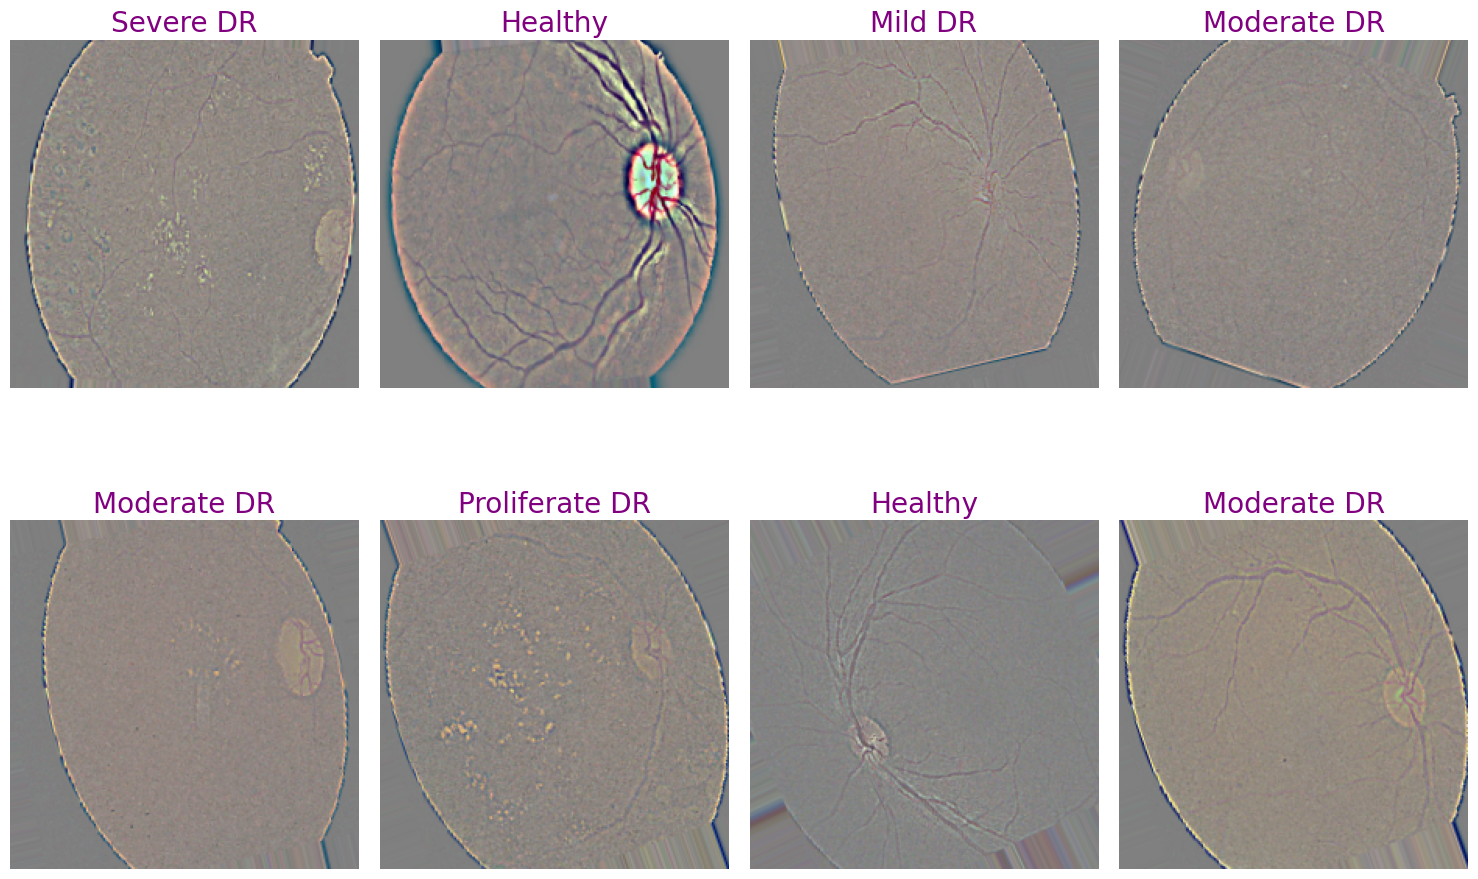

In [239]:
# Define labels and their indices as a dict
L_index = Train.class_indices
L_index

# Store Labels in a list
Keys = list(L_index.keys())
Keys

#Get a sample batch
imgs, labels = next(Train)

# Visualization
plt.figure(figsize= (15, 15))

for i in range(8):
    plt.subplot(3, 4, i +1)
    im = imgs[i]/255
    plt.imshow(im)
    
    #Labelling
    index = np.argmax(labels[i])
    label = Keys[index]
    plt.title(label, color = 'purple')
    plt.axis('off')
    
plt.tight_layout()    
plt.show()

# 4 Modelling

## A- Create a model using transfer learning with EfficientNetB2


#### * NOTE "experts advise you make the base model initially not trainable. Then train for some number of epochs
#### then fine tune model by making base model trainable and run more epochs
#### It was found to be WRONG!!!! 
#### Making the base model trainable from the outset leads to faster convegence and a lower validation loss
#### for the same number of total epochs!"
as mentioned at: https://www.kaggle.com/code/devanshajmera/chair



#### --> I will be using EfficientNetB3 model with weights from imagenet.
##### And I will using include_top=False option since it allows me to add my own output layer.



In [240]:
# Define number of classes 
n_classes = len(list(Train.class_indices.keys()))
n_classes

img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model= EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 

# Note you are always told NOT to make the base model trainable initially- that is WRONG you get better results leaving it trainable
base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.999, epsilon=0.001 )(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.2, seed=123)(x)
x = Dense(512, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.3, seed=123)(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.01),activity_regularizer=regularizers.l1(0.005),
                bias_regularizer=regularizers.l1(0.005) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)
output=Dense(n_classes, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.0001 # start with this learning rate



In [241]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(512, activation='elu'))
model.add(Dense(256, activation='elu'))
model.add(Dense(128, activation = 'elu'))
model.add(Dense(5, activation='softmax'))


In [244]:
model.compile(
    Adamax(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [245]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 dropout_39 (Dropout)        (None, 1536)              0         
                                                                 
 flatten_9 (Flatten)         (None, 1536)              0         
                                                                 
 dense_76 (Dense)            (None, 512)               786944    
                                                                 
 dense_77 (Dense)            (None, 256)               131328    
                                                                 
 dense_78 (Dense)            (None, 128)               32896     
                                                      

## B- Visualize model layers

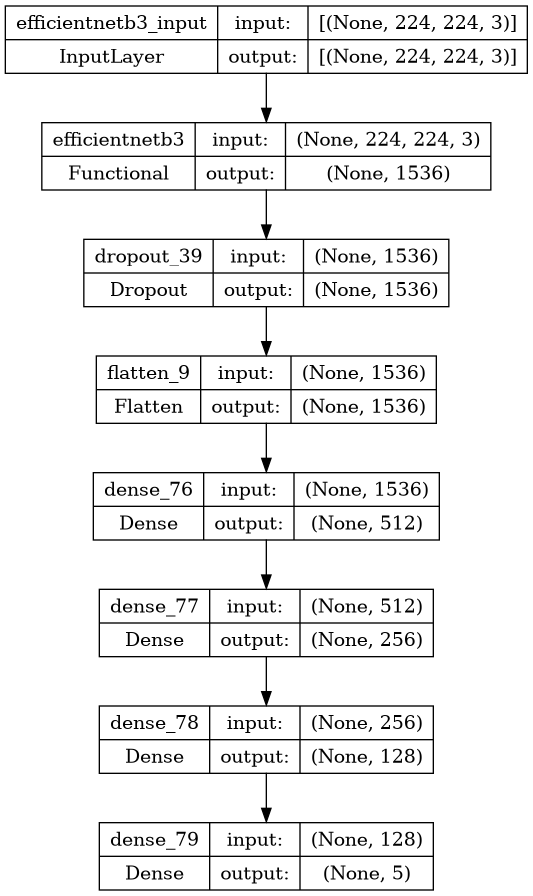

In [246]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png')

## C- Training phase

In [247]:
epochs = 50
history = model.fit(x= Train, epochs= epochs, verbose= 1, validation_data= Valid, validation_steps= None, shuffle= False)

Epoch 1/50


2023-11-28 20:48:18.202652: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/efficientnetb3/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


110/110 [==============================] - 87s 300ms/step - loss: 1.7068 - acc: 0.4900 - val_loss: 1.5328 - val_acc: 0.4655
Epoch 2/50
110/110 [==============================] - 30s 274ms/step - loss: 1.2487 - acc: 0.5636 - val_loss: 0.9812 - val_acc: 0.6291
Epoch 3/50
110/110 [==============================] - 30s 269ms/step - loss: 1.1481 - acc: 0.5850 - val_loss: 0.8741 - val_acc: 0.6691
Epoch 4/50
110/110 [==============================] - 30s 266ms/step - loss: 1.0202 - acc: 0.6150 - val_loss: 0.8269 - val_acc: 0.7164
Epoch 5/50
110/110 [==============================] - 30s 273ms/step - loss: 0.9577 - acc: 0.6359 - val_loss: 0.7892 - val_acc: 0.7273
Epoch 6/50
110/110 [==============================] - 30s 274ms/step - loss: 0.9079 - acc: 0.6605 - val_loss: 0.7603 - val_acc: 0.7164
Epoch 7/50
110/110 [==============================] - 30s 271ms/step - loss: 0.8693 - acc: 0.6636 - val_loss: 0.7449 - val_acc: 0.7309
Epoch 8/50
110/110 [==============================] - 30s 273ms/st

## D- Evaluation 

In [ ]:
# accuracy and loss of Train

tr_acc = history.history['acc']
tr_loss = history.history['loss']


# accuracy and loss or Valid\

v_acc = history.history['val_acc']
v_loss = history.history['val_loss']


# highest value of v_acc by getting its index

index_acc = np.argmax(v_acc)
high_Vacc = v_acc[index_acc]


# lowest value of v_loss by getting index

index_loss = np.argmin(v_loss)
low_Vloss = v_loss[index_loss]


# n. of epochs based on length of tr_acc values

Epochs =[]
for i in range(len(tr_acc)):
    Epochs.append (i+1)

    
# Define best epoch

best_acc = f'Best epoch ={str(index_acc +1)}'
best_loss = f'Best epoch ={str(index_loss+1)}'

## E- Let's Visualize it

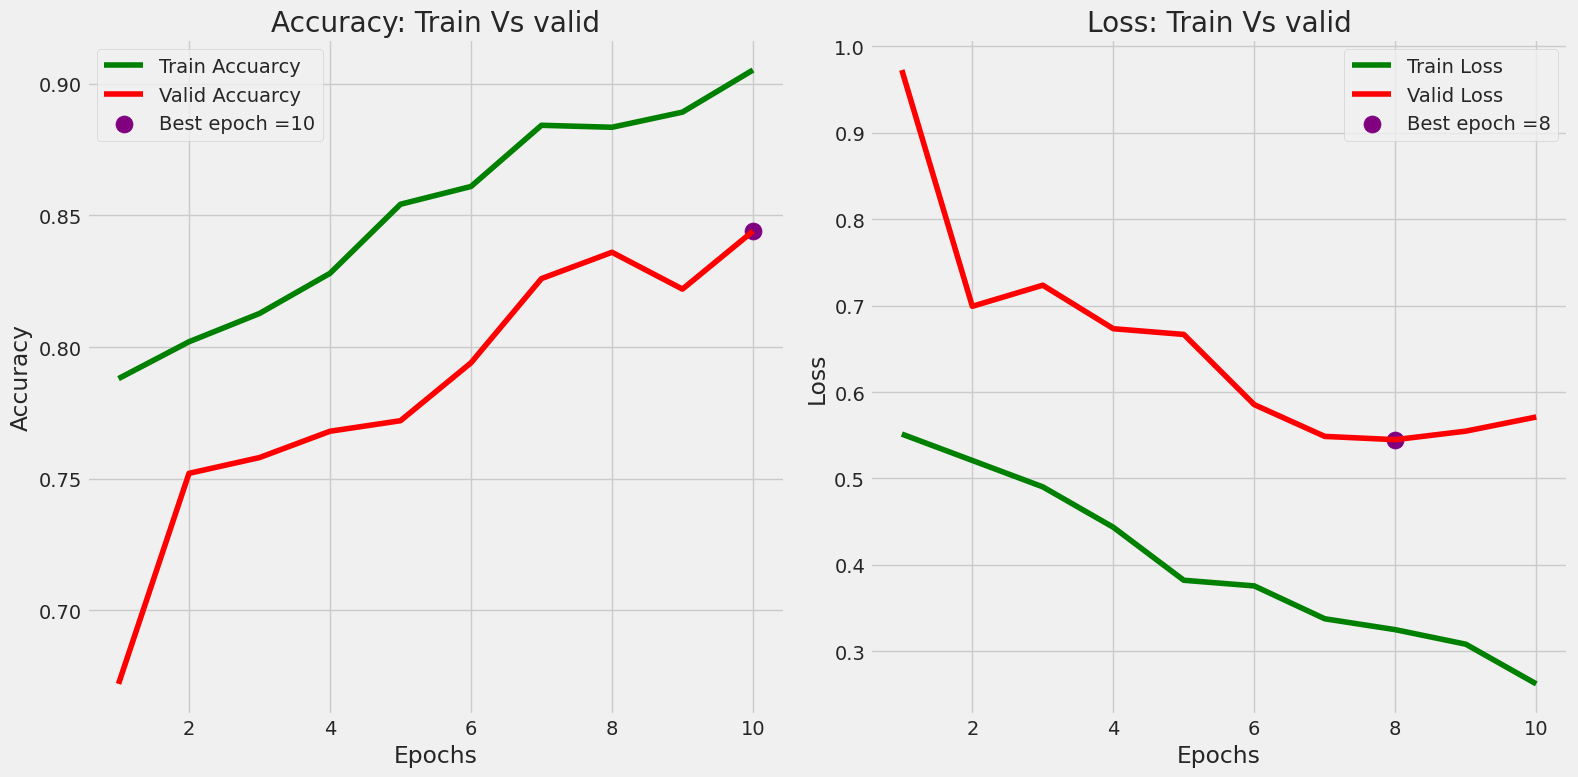

In [249]:
plt.figure(figsize = (16, 8))
plt.style.use('fivethirtyeight')


plt.subplot(1,2,1)
plt.plot(Epochs, tr_acc, "g", label = "Train Accuarcy")
plt.plot(Epochs, v_acc, "r", label = "Valid Accuarcy")
plt.scatter(index_acc+1, high_Vacc, s= 150, color = 'purple', label = best_acc)

plt.title("Accuracy: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(Epochs, tr_loss, "g", label = "Train Loss")
plt.plot(Epochs, v_loss, "r", label = "Valid Loss")
plt.scatter(index_loss+1, low_Vloss, s= 150, color = 'purple', label = best_loss)

plt.title("Loss: Train Vs valid")
plt. xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [250]:
# Define Vars
Train_sc = model.evaluate(Train, verbose = 1)
Valid_sc = model.evaluate(Valid, verbose = 1)
Test_sc =model.evaluate(Test, verbose = 1)

#Print
print('Train Scores : \n    accuracy:', Train_sc[1], '\n      Loss: ', Train_sc[0], '\n________________________')
print('Valid Scores : \n    accuracy:', Valid_sc[1], '\n      Loss: ', Valid_sc[0], '\n________________________')
print('Test Scores : \n    accuracy:', Test_sc[1], '\n      Loss: ', Test_sc[0], '\n________________________')

14/14 [==============================] - 1s 85ms/step - loss: 1.1084 - acc: 0.7636
Train Scores : 
    accuracy: 0.9854545593261719 
      Loss:  0.04416825622320175 
________________________
Valid Scores : 
    accuracy: 0.7127272486686707 
      Loss:  1.3232495784759521 
________________________
Test Scores : 
    accuracy: 0.7636363506317139 
      Loss:  1.1083840131759644 
________________________


# 5 Get  predictions

In [252]:
predictions = model.predict_generator(Test)
y_pred = np.argmax(predictions, axis = 1)

#Chack
print(predictions)
print(y_pred)

[[1.00000000e+00 5.08913232e-08 4.40666126e-09 1.04724840e-10
  1.31037623e-13]
 [9.99970675e-01 2.90676016e-05 2.84390211e-07 2.13604379e-09
  4.06067367e-12]
 [1.10377496e-05 7.93138240e-03 9.91905689e-01 3.13645251e-05
  1.20490324e-04]
 ...
 [6.92501199e-05 9.80753481e-01 1.80223081e-02 1.12739159e-03
  2.76429255e-05]
 [9.99968767e-01 1.11298085e-07 3.10895448e-05 5.55310820e-09
  1.43791382e-10]
 [4.05122229e-08 4.93995549e-06 9.99992013e-01 2.24015082e-07
  2.75742423e-06]]
[0 0 2 1 2 0 2 1 0 1 1 0 0 2 1 2 1 1 1 0 0 0 0 2 1 1 1 2 1 2 2 0 0 3 0 1 1
 2 2 2 0 3 2 1 2 1 0 2 0 2 1 1 2 3 1 0 2 0 4 2 0 2 1 2 0 2 0 0 0 2 0 2 0 0
 1 2 2 1 0 0 2 1 2 2 0 3 0 4 1 1 2 1 2 1 0 4 2 2 2 2 1 1 4 2 0 0 0 2 1 2 2
 0 2 2 0 2 0 4 2 2 0 2 0 1 1 3 1 0 0 2 0 1 0 2 2 2 0 0 2 1 0 0 0 0 0 0 0 0
 0 4 0 0 0 0 1 0 0 2 1 2 2 0 2 0 1 2 0 0 1 0 2 0 2 2 1 3 0 0 0 1 2 1 1 2 0
 2 0 2 2 1 2 0 2 0 0 3 2 2 1 1 2 1 0 2 0 4 1 2 2 0 2 0 2 2 0 0 1 0 1 0 2 2
 2 2 2 2 2 2 4 0 2 0 0 0 0 2 0 0 1 2 0 0 2 2 0 3 0 0 1 0 0 1 4 1

In [253]:
# Use n. of keys of  Class indices to greate confusion matrix
Test_cl_ind = Test.class_indices
 
# Get Keys
classes = list(Test_cl_ind.keys())

#CM
cm = confusion_matrix(Test.classes, y_pred)
cm

array([[97,  2,  0,  0,  0],
       [ 4, 35,  7,  0,  0],
       [ 2, 16, 67,  0,  5],
       [ 0,  4, 11,  6,  1],
       [ 0,  2,  8,  3,  5]])

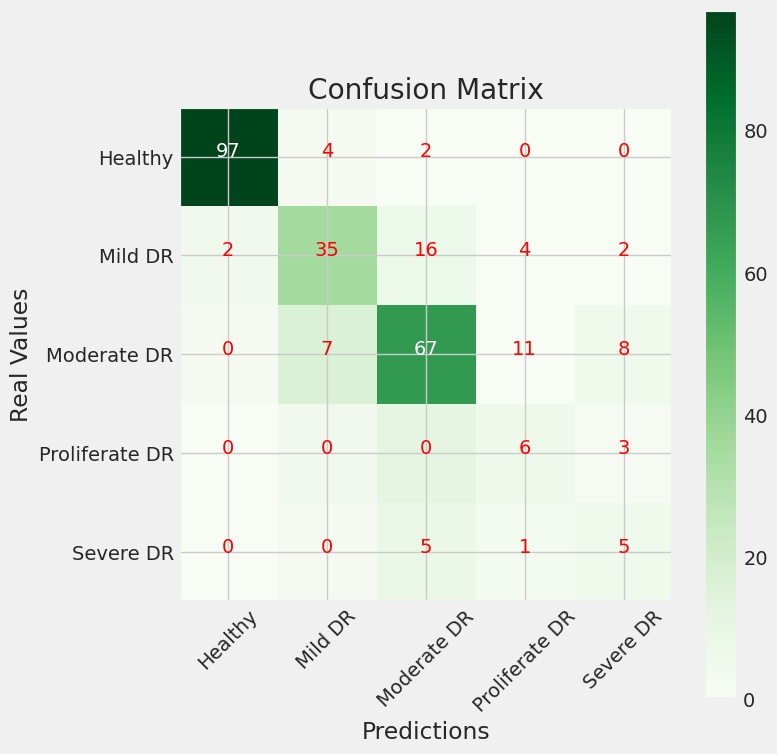

In [254]:
#visualise it
plt.figure(figsize =(8, 8))
plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes,rotation = 45)
plt.yticks(tick_marks, classes)

thresh = cm.max()/2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(i, j, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i,j] > thresh  else 'red')
    
plt.tight_layout()
plt.xlabel('Predictions')
plt.ylabel('Real Values')
plt.show()

In [255]:
# Calssification Report
print(classification_report(Test.classes, y_pred, target_names = classes))


                precision    recall  f1-score   support

       Healthy       0.94      0.98      0.96        99
       Mild DR       0.59      0.76      0.67        46
   Moderate DR       0.72      0.74      0.73        90
Proliferate DR       0.67      0.27      0.39        22
     Severe DR       0.45      0.28      0.34        18

      accuracy                           0.76       275
     macro avg       0.68      0.61      0.62       275
  weighted avg       0.76      0.76      0.75       275



# 7 Save model

In [256]:
model.save('effB3 CNN DR.h5')

#### If you found it useful...please upvote it!

#### Thank you